In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
train = pd.read_csv('data/train.csv.zip',index_col='id')
train.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
id,,,,,,
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [3]:
test = pd.read_csv('data/test.csv.zip',index_col='id')
test.head()

,bone_length,rotting_flesh,hair_length,has_soul,color
id,,,,,
3,0.471774,0.387937,0.706087,0.698537,black
6,0.427332,0.645024,0.565558,0.451462,white
9,0.549602,0.491931,0.660387,0.449809,black
10,0.638095,0.682867,0.471409,0.356924,white
13,0.361762,0.583997,0.377256,0.276364,black


In [4]:
def prepare(data):
    data['hair_soul'] = data['hair_length'] * data['has_soul']
    data['hair_bone'] = data['hair_length'] * data['bone_length']
    data['hair_soul_bone'] = data['hair_length'] * data['has_soul'] * data['bone_length']

In [5]:
prepare(train)
prepare(test)

In [6]:
train.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type,hair_soul,hair_bone,hair_soul_bone
id,,,,,,,,,
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0.363825,0.165118,0.128980
1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0.233763,0.305853,0.134545
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,0.642171,0.379735,0.300456
4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,0.563196,0.494546,0.437408
5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0.266409,0.236973,0.150818


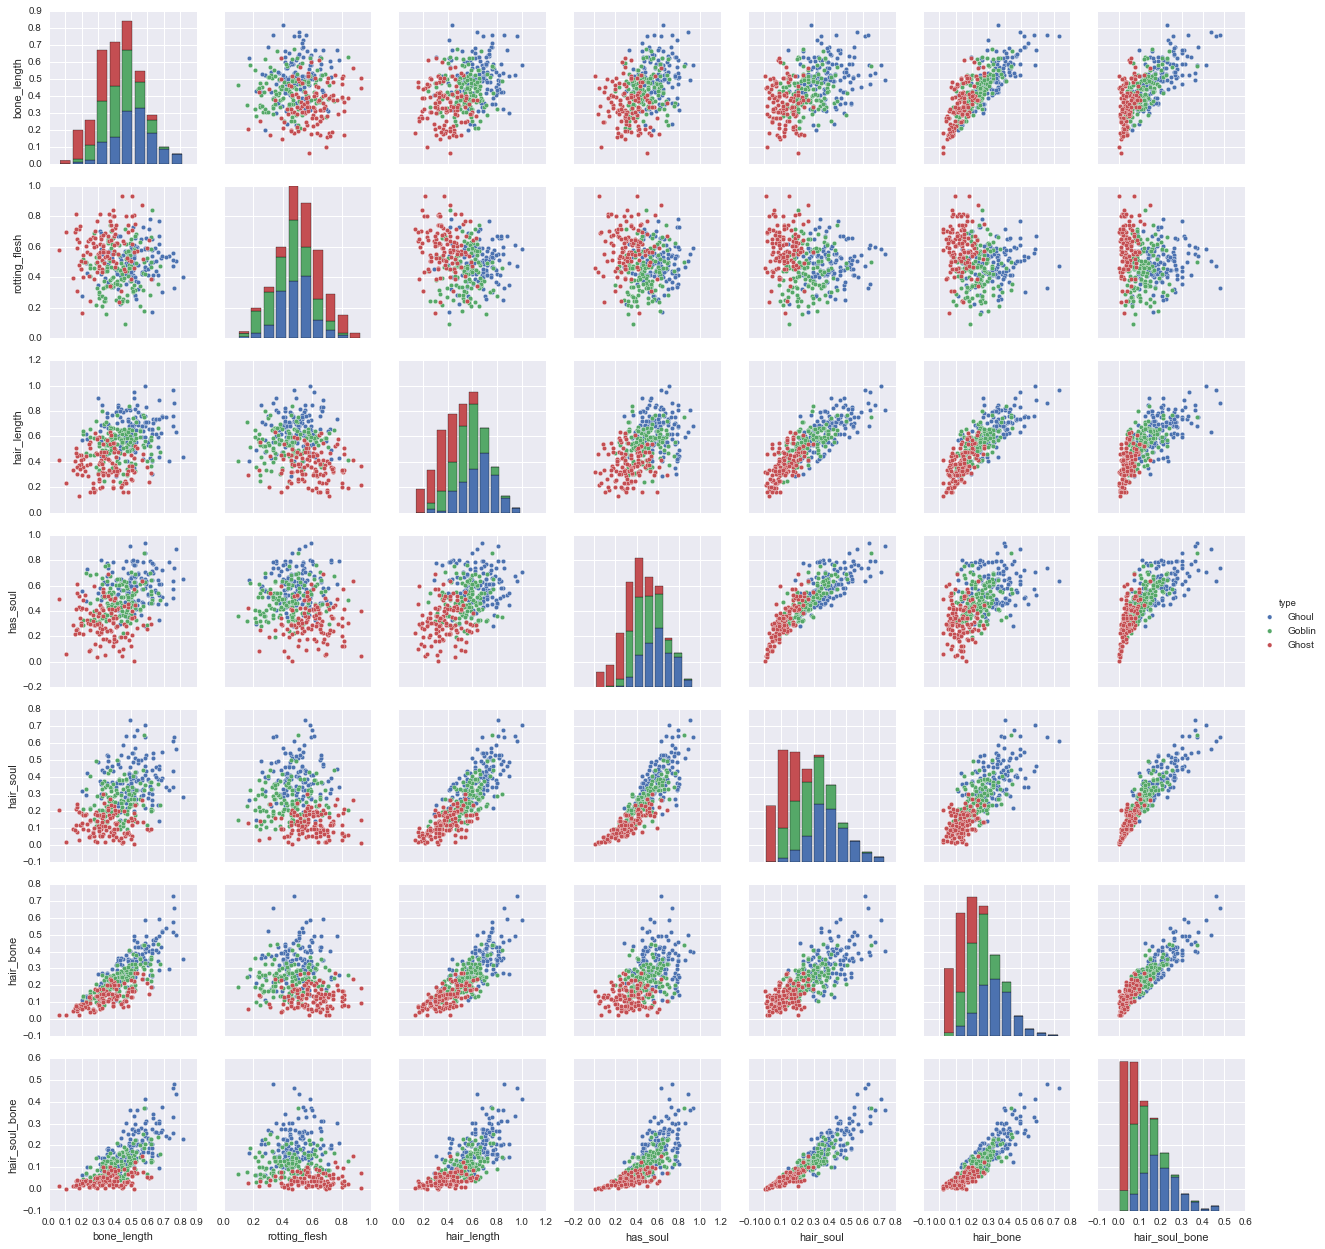

In [7]:
sns.set()
sns.pairplot(train, hue='type')

In [8]:
le = LabelEncoder()
Y_train = le.fit_transform(train['type'].values)
X_train = train.drop(['type'], axis=1)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(test)

In [9]:
X_train.head()

,bone_length,rotting_flesh,hair_length,has_soul,hair_soul,hair_bone,hair_soul_bone,color_black,color_blood,color_blue,color_clear,color_green,color_white
id,,,,,,,,,,,,,
0,0.354512,0.350839,0.465761,0.781142,0.363825,0.165118,0.128980,0,0,0,1,0,0
1,0.575560,0.425868,0.531401,0.439899,0.233763,0.305853,0.134545,0,0,0,0,1,0
2,0.467875,0.354330,0.811616,0.791225,0.642171,0.379735,0.300456,1,0,0,0,0,0
4,0.776652,0.508723,0.636766,0.884464,0.563196,0.494546,0.437408,1,0,0,0,0,0
5,0.566117,0.875862,0.418594,0.636438,0.266409,0.236973,0.150818,0,0,0,0,1,0


In [10]:
def testVariablesRfc(X, Y):
    clf = RandomForestClassifier(n_estimators=200)
    clf = clf.fit(X, Y)
    indices = np.argsort(clf.feature_importances_)[::-1]
    for f in range(X.shape[1]):
        print('%d. feature %d %s (%f)' % (f + 1, indices[f], X.columns[indices[f]],
                                          clf.feature_importances_[indices[f]]))

In [11]:
testVariablesRfc(X_train, Y_train)

1. feature 6 hair_soul_bone (0.213515)
2. feature 4 hair_soul (0.180223)
3. feature 5 hair_bone (0.134397)
4. feature 2 hair_length (0.123642)
5. feature 3 has_soul (0.116184)
6. feature 1 rotting_flesh (0.112017)
7. feature 0 bone_length (0.081402)
8. feature 10 color_clear (0.008940)
9. feature 12 color_white (0.008602)
10. feature 11 color_green (0.007122)
11. feature 7 color_black (0.006329)
12. feature 9 color_blue (0.005795)
13. feature 8 color_blood (0.001832)


In [12]:
def save(fname, pred, test):
    res1 = pd.DataFrame()
    res1['id'] = test.index
    res1['type'] = pred
    res1.to_csv("submissions/{0}.csv".format(fname), index=False)
    res1

In [13]:
def findParamsLRC(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    clf = LogisticRegression(random_state=42)
    parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                      'multi_class' : ['ovr', 'multinomial'],
                      'C' : [0.005, 0.01, 1, 10, 100, 1000],
                      'tol': [0.0001, 0.001, 0.005]
                     }
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5))
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

findParamsLRC(X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1), Y_train)    

Best score: 0.7644787644787645
Best parameters: {'multi_class': 'multinomial', 'C': 1, 'solver': 'newton-cg', 'tol': 0.0001}


In [14]:
def findParamsRFC(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    parameter_grid = {'n_estimators' : [10, 20, 100, 150],
                     'criterion' : ['gini', 'entropy'],
                     'max_features' : ['auto', 'sqrt', 'log2', None],
                     'max_depth' : [None, 5, 20, 100],
                     'min_samples_split' : [2, 5, 7],
                     'min_weight_fraction_leaf' : [0.0, 0.1],
                     'max_leaf_nodes' : [40, 60, 80]
                    }
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5))
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

findParamsRFC(X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1), Y_train)    

Best score: 0.7374517374517374
Best parameters: {'max_leaf_nodes': 40, 'min_weight_fraction_leaf': 0.1, 'criterion': 'entropy', 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'max_features': None}


In [15]:
def findParamsSVC(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    clf = SVC(random_state=42)
    parameter_grid = {'kernel' : ['linear', 'rbf', 'sigmoid', 'poly'],
                      'C' : [0.005, 0.01, 1, 10, 100, 1000],
                      'tol': [0.0001, 0.001, 0.005]
                     }
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5))
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

findParamsSVC(X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1), Y_train)

Best score: 0.7606177606177607
Best parameters: {'C': 100, 'kernel': 'linear', 'tol': 0.001}


In [16]:
def findParamsKNN(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    clf = KNeighborsClassifier()
    parameter_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12], 
                      'weights': ['uniform',  'distance']}
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5))
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

findParamsKNN(X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1), Y_train)

Best score: 0.7760617760617761
Best parameters: {'weights': 'uniform', 'n_neighbors': 11}


In [17]:
def findParamsGPC(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    clf = GaussianProcessClassifier(random_state=42)
    parameter_grid = {'multi_class': ['one_vs_rest', 'one_vs_one']}
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5))
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

findParamsGPC(X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1), Y_train)  

Best score: 0.7644787644787645
Best parameters: {'multi_class': 'one_vs_rest'}


In [18]:
def parse(pred):
    return pd.DataFrame(pred, columns=le.classes_).idxmax(axis=1).values

def rename(data):
    return [le.classes_[i] for i in data]

def classify(X, Y, X_test):
    lrc = LogisticRegression(tol=0.0001, C=1, multi_class='multinomial',solver='newton-cg')
    rfc = RandomForestClassifier(max_depth=None, min_weight_fraction_leaf=0.1, criterion='entropy', max_features=None, max_leaf_nodes=40, n_estimators=100, min_samples_split=2)
    svc = SVC(kernel='linear', C=100, tol=0.001, probability=True)
    knn = KNeighborsClassifier(weights='uniform', n_neighbors=11)
    gpc = GaussianProcessClassifier(multi_class='one_vs_rest')
    
    for clf in [lrc, rfc, svc, knn, gpc]:
        clf.fit(X, Y)
    
    lrc_pred = parse(lrc.predict_proba(X_test))
    rfc_pred = parse(rfc.predict_proba(X_test))
    svc_pred = parse(svc.predict_proba(X_test))
    knn_pred = parse(knn.predict_proba(X_test))
    gpc_pred = parse(gpc.predict_proba(X_test))
    
    pred = []
    for i in range(len(lrc_pred)):
        arr = [lrc_pred[i],lrc_pred[i],knn_pred[i],rfc_pred[i],svc_pred[i],gpc_pred[i],gpc_pred[i]]
        counter = Counter(arr)
        c = counter.most_common()[0][0]
        if len(counter) > 1:
            print(i, lrc_pred[i],knn_pred[i],rfc_pred[i],svc_pred[i],gpc_pred[i], '| Common: ' + c)
        pred.append(c)
        
    return pred

In [19]:
def check(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    pred = classify(X_train, y_train, X_test)
    print(classification_report(rename(y_test), pred))

check(X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1), Y_train)

0 Goblin Ghoul Goblin Goblin Goblin | Common: Goblin
9 Ghost Ghost Goblin Ghost Ghost | Common: Ghost
10 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
13 Goblin Ghoul Goblin Goblin Ghoul | Common: Goblin
18 Goblin Goblin Goblin Goblin Ghost | Common: Goblin
32 Ghost Ghost Ghost Goblin Ghost | Common: Ghost
34 Goblin Goblin Goblin Goblin Ghoul | Common: Goblin
36 Ghost Ghost Ghost Goblin Ghost | Common: Ghost
38 Ghost Goblin Ghost Ghost Ghost | Common: Ghost
42 Ghost Ghost Ghost Goblin Ghost | Common: Ghost
45 Goblin Goblin Goblin Goblin Ghoul | Common: Goblin
52 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
53 Ghost Goblin Ghost Goblin Ghost | Common: Ghost
55 Goblin Ghoul Goblin Goblin Goblin | Common: Goblin
58 Goblin Goblin Ghost Goblin Goblin | Common: Goblin
71 Ghost Ghost Ghost Goblin Ghost | Common: Ghost
79 Goblin Goblin Ghost Goblin Goblin | Common: Goblin
80 Ghost Ghost Ghost Goblin Ghost | Common: Ghost
82 Ghoul Ghoul Goblin Goblin Ghoul | Common: Ghoul
85 Ghoul Goblin Gob

In [20]:
X_test_ = X_test.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1)
X_train_ = X_train.drop(['color_black','color_blood','color_blue','color_clear','color_green','color_white'], axis=1)
pred = classify(X_train_, Y_train, X_test_)

3 Ghost Ghost Goblin Goblin Ghost | Common: Ghost
12 Goblin Goblin Ghost Goblin Goblin | Common: Goblin
16 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
21 Goblin Ghoul Ghoul Goblin Goblin | Common: Goblin
23 Ghost Goblin Goblin Goblin Ghost | Common: Ghost
24 Goblin Ghoul Goblin Goblin Ghoul | Common: Goblin
30 Goblin Goblin Ghoul Goblin Goblin | Common: Goblin
41 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
44 Goblin Goblin Ghost Goblin Goblin | Common: Goblin
51 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
57 Ghoul Goblin Goblin Ghoul Ghoul | Common: Ghoul
65 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
67 Ghoul Ghoul Goblin Ghoul Ghoul | Common: Ghoul
68 Goblin Ghost Goblin Goblin Ghost | Common: Goblin
70 Ghost Goblin Goblin Goblin Ghost | Common: Ghost
71 Ghost Ghost Goblin Ghost Ghost | Common: Ghost
76 Ghoul Goblin Ghoul Ghoul Ghoul | Common: Ghoul
77 Goblin Goblin Ghoul Ghoul Ghoul | Common: Ghoul
93 Goblin Ghost Goblin Goblin Goblin | Common: Goblin
96 Goblin Ghost Gob

In [21]:
save('combo_2', pred, X_test_)